In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import lzma

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 1000
#plt.style.use('ggplot')
plt.style.use('seaborn-paper')
mpl.rcParams['axes.linewidth'] = 0.7

In [2]:
file = "latest_results.json.xz"

data = None
if file.endswith('.xz'): file = lzma.open(file, 'rt')
data = pd.read_json(file)
data = data.sort_values(['file', 'method'])

In [3]:
data = data[data.method != 'reforest']

In [4]:
# Adding a column for the database
data['db'] = -1 + \
    (0+1)*data.file.str.endswith(')') + \
    (1+1)*data.file.str.contains('/Prover9--') + \
    (2+1)*data.file.str.contains('/Vampire---4.0') + \
    (3+1)*data.file.str.contains('/leanCoP--') + \
    (4+1)*data.file.str.contains('/QF_UF/')
    
data['status'] = data.status.fillna("timeout_" + data.phase)

data['is_smaller'] = (data.status=='ok') & (data.ehs_lkinf < data.hs_lkinf)
data['is_larger'] = (data.status=='ok') & (data.ehs_lkinf >= data.hs_lkinf)
data['is_trivial'] = data.status.str.endswith('termset_trivial')
data['is_uncompressible'] = data.status.str.endswith('uncompressible')
data['is_timeout'] = data.status.str.startswith('timeout')
data['is_error'] = ~data.is_smaller & ~data.is_larger & ~data.is_trivial & ~data.is_uncompressible & ~data.is_timeout

data['tstp_cat'] = data.file.str.extract('/([A-Z]{3,3})/', expand=False)
data['is_tstp'] = data.tstp_cat.notnull()

data['compression_ratio'] = data.termset/data.grammar_size
data['inv_compression_ratio'] = data.grammar_size/data.termset

data['lk_cmp_ratio'] = data.ehs_lkinf/data.hs_lkinf

data['has_sol'] = data.time_beausol>=0

In [5]:
# Other exceptions (aka bugs to hunt)

data_other_exp = data[(data.status == 'cutintro_other_exception')]
data_other_exp[['method', 'file', 'status']].sort_index()

,method,file,status
8,1_1_maxsat,proofs/Solutions/SCT/SCT171+2/SInE---0.4.THM-CRf.s,cutintro_other_exception
9,2_maxsat,proofs/Solutions/SCT/SCT171+2/SInE---0.4.THM-CRf.s,cutintro_other_exception
12,2_2_maxsat,proofs/Solutions/SCT/SCT171+2/SInE---0.4.THM-CRf.s,cutintro_other_exception
14,1_maxsat,proofs/Solutions/SCT/SCT171+2/SInE---0.4.THM-CRf.s,cutintro_other_exception
72,1_1_maxsat,proofs/Solutions/CSR/CSR025+2/iProver---2.0.THM-CRf.s,cutintro_other_exception
73,2_maxsat,proofs/Solutions/CSR/CSR025+2/iProver---2.0.THM-CRf.s,cutintro_other_exception
76,2_2_maxsat,proofs/Solutions/CSR/CSR025+2/iProver---2.0.THM-CRf.s,cutintro_other_exception
78,1_maxsat,proofs/Solutions/CSR/CSR025+2/iProver---2.0.THM-CRf.s,cutintro_other_exception
240,1_1_maxsat,proofs/Solutions/SWC/SWC365-1/VampireZ3---1.0.UNS-Ref.s,cutintro_other_exception
241,2_maxsat,proofs/Solutions/SWC/SWC365-1/VampireZ3---1.0.UNS-Ref.s,cutintro_other_exception


In [6]:
methods = sorted(set(data.method.dropna()))

dbs = {
    0: 'Proof examples',
    1: 'Prover9',
    2: 'Vampire',
    3: 'LeanCoP',
    4: 'VeriT',
}

dbs = { i: dbs[i] for i in dbs.keys() if i in data.db.values }

In [7]:
#print("=== Number of tests per database and method:\n")

#for dbi, dbname in dbs.items():
#    for method in methods:
#        print("{0} - {1}: {2}".format(dbname, method,
#                                     data[(data.method==method) & (data.db==dbi)].shape[0]))
#    print()

In [8]:
states = set(data.status.values)
status_colors = {}
for s in states:
    if s == 'ok':
        c = 'green'
    elif s == 'cutintro_uncompressible':
        c = 'yellow'
    elif s == 'cutintro_termset_trivial':
        c = 'gold'
    elif 'timeout' in s:
        c = plt.cm.Blues(hash(s)/2**65+0.5)
    elif s.endswith('exception'):
        c = plt.cm.Reds(hash(s)/2**65+0.5)
    else:
        c = plt.cm.Greys(hash(s)/2**65+0.5)
    status_colors[s] = c

def plot_status(d, legend=True, **kwargs):
    plt.axis('equal')
    d.plot(kind='pie', autopct='%1.1f%%',
                        colors=[status_colors[s] for s in d.index], **kwargs) \
        .set_ylabel('')
    if legend: plt.legend(d.index, loc='center left', bbox_to_anchor=(1, 0.5))

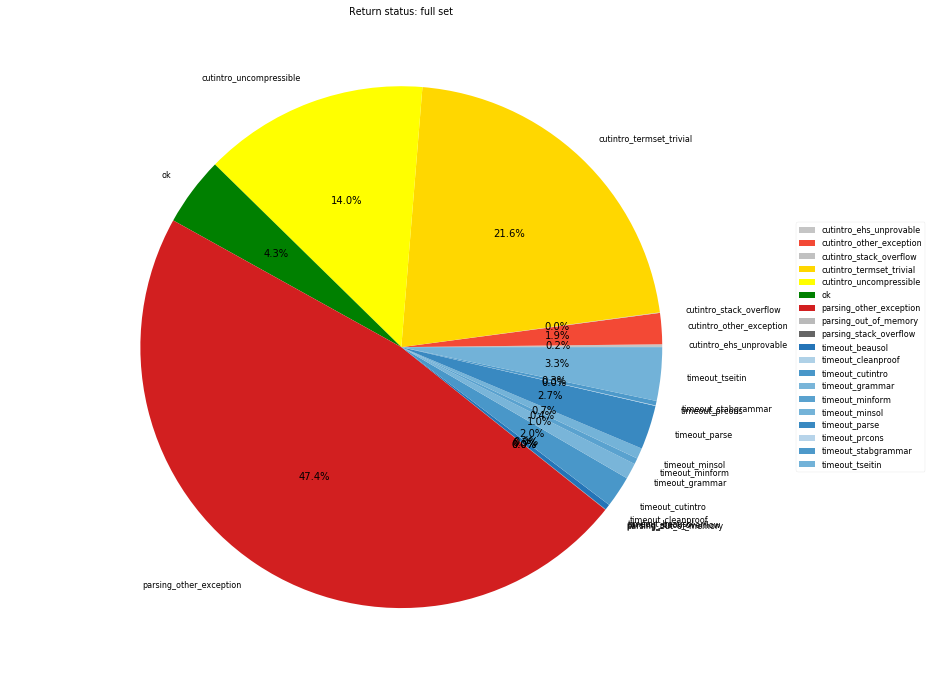

In [9]:
plot_status(data.groupby('status').size(), figsize=(14,12), title='Return status: full set')

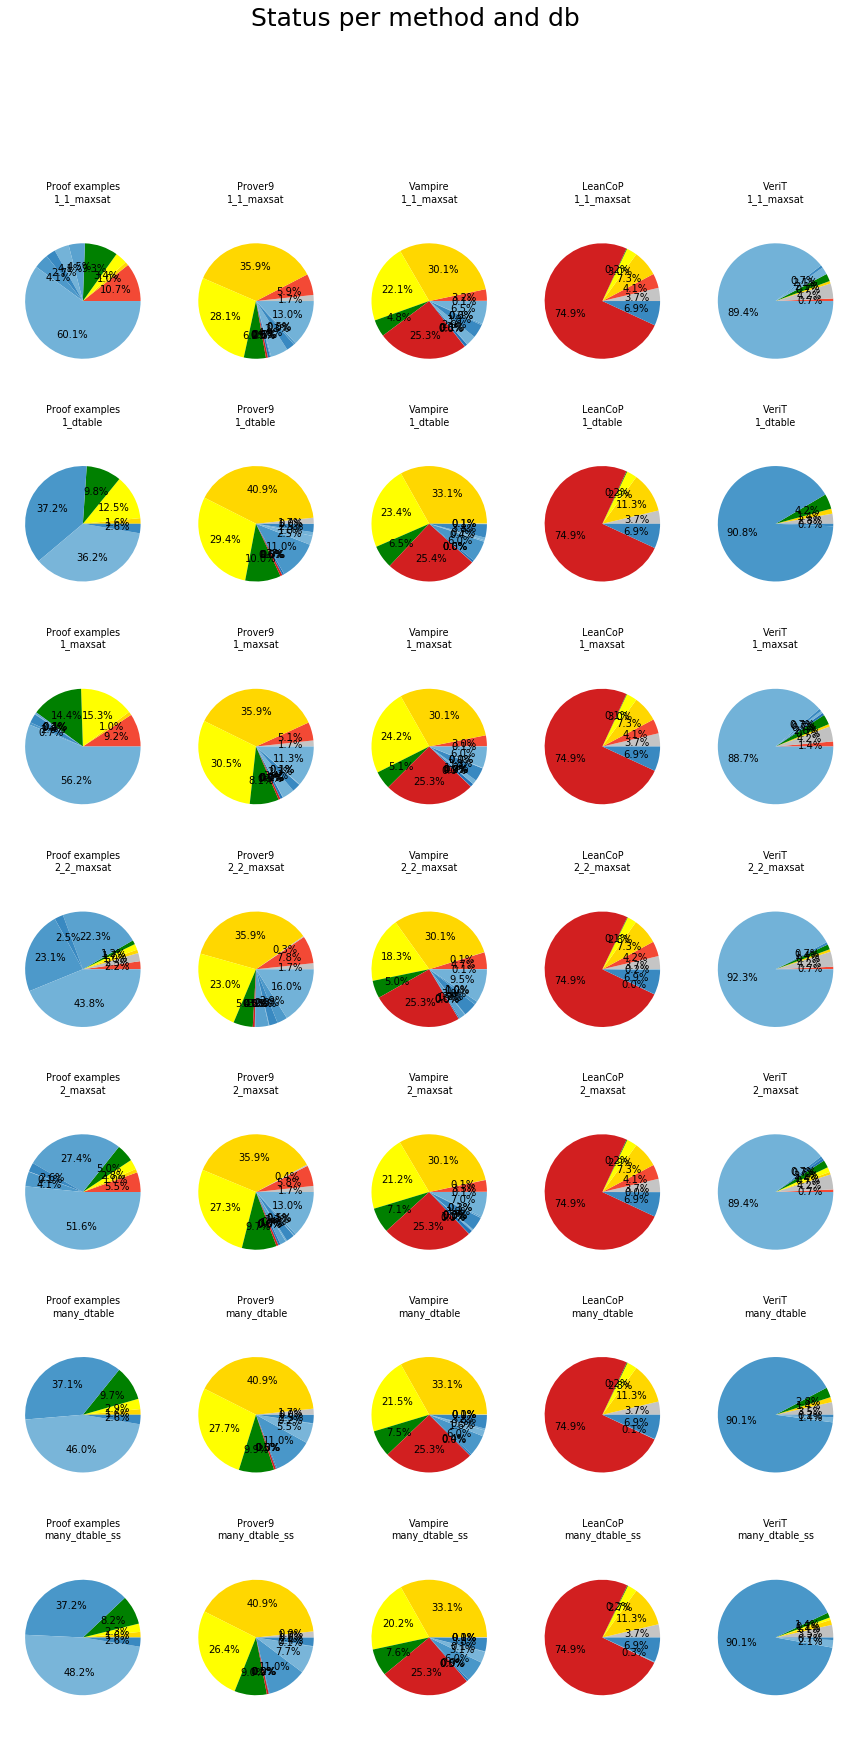

In [10]:
xsize, ysize = len(dbs.items()), len(methods)
plt.figure(1, figsize=(3*xsize,4*ysize))
plt.suptitle('Status per method and db', fontsize=25)
for j, (dbi, db) in enumerate(dbs.items()):
    for i, method in enumerate(methods):
        plt.subplot(ysize, xsize, i*xsize + j + 1)
        subdata = data[(data.db==dbi) & (data.method==method)].groupby('status').size()
        plot_status(subdata, title='{0}\n{1}'.format(db,method), labels=None, legend=False)

In [11]:
timecols = ['time_grammar', 'time_minsol', 'time_prcons', 'time_cleanproof']
#plt.axis('equal')
#data[timecols].mean().plot(kind='pie', figsize=(12,12), autopct='%1.1f%%',
#                           title='Time: full set', legend=True).set_ylabel('')

In [12]:
#xsize, ysize = len(dbs.items()), len(methods)
#plt.figure(1, figsize=(3*xsize,4*ysize))
#plt.suptitle('Time consumption per method and db', fontsize=25)
#for i, method in enumerate(methods):
#    for j, (dbi, db) in enumerate(dbs.items()):
#        plt.subplot(ysize, xsize, i*xsize + j + 1)
#        plt.axis('equal')
#        data[(data.db==dbi) & (data.method==method)][timecols].mean() \
#            .plot(kind='pie', autopct='%1.1f%%', labels=None,
#                  title='{0}\n{1}'.format(db,method)).set_ylabel('')
#plt.legend(timecols, loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
#xsize, ysize = len(dbs.items()), len(methods)
#plt.figure(1, figsize=(3*xsize,4*ysize))
#plt.suptitle('Time consumption per method and db, state==ok', fontsize=25)
#for i, method in enumerate(methods):
#    for j, (dbi, db) in enumerate(dbs.items()):
#        plt.subplot(ysize, xsize, i*xsize + j + 1)
#        plt.axis('equal')
#        ax = data[(data.db==dbi) & (data.method==method) & (data.status=='ok')][timecols].mean() \
#            .plot(kind='pie', autopct='%1.1f%%', labels=None,
#                  title='{0}\n{1}'.format(db,method))
#        ax.set_ylabel('')
#plt.legend(timecols, loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
data['status'].value_counts()

parsing_other_exception     462016
cutintro_termset_trivial    210458
cutintro_uncompressible     136070
ok                           41649
timeout_tseitin              32283
timeout_parse                26637
timeout_cutintro             19032
cutintro_other_exception     18754
timeout_grammar               9631
timeout_minsol                6500
timeout_minform               3649
timeout_beausol               3382
timeout_stabgrammar           2714
cutintro_ehs_unprovable       1708
cutintro_stack_overflow        330
timeout_prcons                 308
parsing_stack_overflow         134
parsing_out_of_memory          105
timeout_cleanproof              41
Name: status, dtype: int64

In [15]:
# Different grammar sizes between different methods: one cut with one quantifier
data_dtable = data[(data.method == '1_dtable') & data.grammar_size]
data_maxsat = data[(data.method == '1_maxsat') & data.grammar_size]

merged = pd.merge(data_dtable, data_maxsat, on=['file'], suffixes=('_dtable', '_maxsat'))
merged[merged.grammar_size_dtable != merged.grammar_size_maxsat] \
    [['file', 'grammar_size_dtable', 'grammar_size_maxsat']]

,file,grammar_size_dtable,grammar_size_maxsat
75,SquareEdges2DimExampleProof(10),19.0,16.0
76,SquareEdges2DimExampleProof(11),20.0,16.0
77,SquareEdges2DimExampleProof(12),21.0,16.0
78,SquareEdges2DimExampleProof(13),23.0,18.0
79,SquareEdges2DimExampleProof(14),24.0,18.0
80,SquareEdges2DimExampleProof(15),25.0,18.0
81,SquareEdges2DimExampleProof(16),26.0,18.0
82,SquareEdges2DimExampleProof(17),28.0,20.0
85,SquareEdges2DimExampleProof(6),13.0,12.0
86,SquareEdges2DimExampleProof(7),15.0,14.0


In [16]:
# Different grammar sizes between different methods: one cut with multiple quantifiers
data_dtable = data[(data.method == 'many_dtable') & data.grammar_size]
data_maxsat = data[(data.method == '2_maxsat') & data.grammar_size]

merged = pd.merge(data_dtable, data_maxsat, on=['file'], suffixes=('_dtable', '_maxsat'))
merged[merged.grammar_size_dtable != merged.grammar_size_maxsat] \
    [['file', 'grammar_size_dtable', 'grammar_size_maxsat']]

,file,grammar_size_dtable,grammar_size_maxsat
0,FactorialFunctionEqualityExampleProof(3),31.0,26.0
1,FactorialFunctionEqualityExampleProof(4),36.0,27.0
2,FactorialFunctionEqualityExampleProof2(10),24.0,16.0
3,FactorialFunctionEqualityExampleProof2(11),26.0,17.0
4,FactorialFunctionEqualityExampleProof2(2),11.0,10.0
5,FactorialFunctionEqualityExampleProof2(3),13.0,11.0
6,FactorialFunctionEqualityExampleProof2(4),15.0,12.0
7,FactorialFunctionEqualityExampleProof2(5),17.0,13.0
8,FactorialFunctionEqualityExampleProof2(6),18.0,14.0
9,FactorialFunctionEqualityExampleProof2(7),20.0,15.0


In [17]:
# Better compression with 2x2 quantifiers than 1x2 quantifiers or 2x1 quantifiers
data_1x2 = data[(data.method == '2_maxsat') & data.grammar_size]
data_2x1 = data[(data.method == '1_1_maxsat') & data.grammar_size]
data_2x2 = data[(data.method == '2_2_maxsat') & data.grammar_size]

merged = data_1x2.merge(data_2x1, on='file', suffixes=('_1x2', '_2x1')) \
    .merge(data_2x2, on='file')
merged[(merged.grammar_size < merged.grammar_size_1x2) & (merged.grammar_size < merged.grammar_size_2x1)] \
    [['file', 'grammar_size', 'grammar_size_2x1', 'grammar_size_1x2']]

,file,grammar_size,grammar_size_2x1,grammar_size_1x2
55,proofs/Solutions/ALG/ALG074+1/ET---0.2.THM-CRf.s,15.0,17.0,16.0
117,proofs/Solutions/ALG/ALG440-1/E---1.9.1.UNS-CRf.s,19.0,21.0,20.0
118,proofs/Solutions/ALG/ALG440-1/E---FNT-1.9.1.UNS-CRf.s,19.0,21.0,20.0
119,proofs/Solutions/ALG/ALG440-1/ET---0.2.UNS-CRf.s,21.0,23.0,24.0
120,proofs/Solutions/ALG/ALG440-1/Prover9---1109a.UNS-Ref.s,21.0,23.0,23.0
121,proofs/Solutions/ALG/ALG440-1/Vampire---4.0.UNS-Ref.s,21.0,23.0,23.0
145,proofs/Solutions/BOO/BOO012-2/Prover9---1109a.UNS-Ref.s,16.0,19.0,17.0
146,proofs/Solutions/BOO/BOO012-3/ET---0.2.UNS-CRf.s,19.0,22.0,20.0
161,proofs/Solutions/BOO/BOO016-1/Vampire---4.0.UNS-Ref.s,21.0,25.0,23.0
162,proofs/Solutions/BOO/BOO017-2/VampireZ3---1.0.UNS-Ref.s,17.0,19.0,18.0


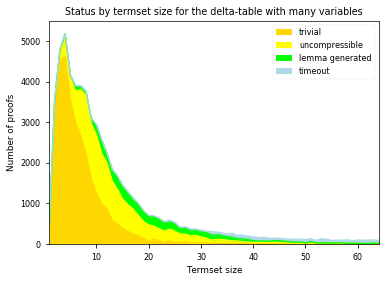

In [44]:
data['is_ok'] = data['status']=='ok'
summary = (data[(data.termset<65)&data.is_tstp&(data.method=='many_dtable_ss')].groupby('termset').sum() \
    [['is_trivial', 'is_uncompressible', 'is_ok', 'is_timeout']] * 1)
summary.columns = ['trivial', 'uncompressible', 'lemma generated', 'timeout']
summary.plot(kind='area', figsize=(5.5,4), ylim=(0,5500),
          title='Status by termset size for the delta-table with many variables',
          color=['gold', 'yellow', 'lime', 'lightblue', 'tomato'])
plt.ylabel("Number of proofs")
plt.xlabel("Termset size")
plt.tight_layout()
plt.savefig('status_by_termset.pdf')

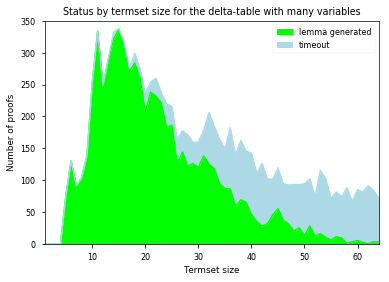

In [47]:
data['is_ok'] = data['status']=='ok'
summary = (data[(data.termset<65)&data.is_tstp&(data.method=='many_dtable_ss')].groupby('termset').sum() \
    [['is_ok', 'is_timeout']] * 1)
summary.columns = ['lemma generated', 'timeout']
summary.plot(kind='area', figsize=(5.5,4), ylim=(0,350),
          title='Status by termset size for the delta-table with many variables',
          color=['lime', 'lightblue', 'tomato'])
plt.ylabel("Number of proofs")
plt.xlabel("Termset size")
plt.tight_layout()
plt.savefig('status_by_termset2.pdf')

In [19]:
# Proofs with good compression of EHS/HS
data[(data.ehs_lkinf/data.hs_lkinf < 0.2)].sort_values('lk_cmp_ratio') \
    [['file', 'method', 'ehs_lkinf', 'hs_lkinf', 'lkinf_input', 'beausol']]

,file,method,ehs_lkinf,hs_lkinf,lkinf_input,beausol
313775,proofs/Solutions/SYN/SYN328+1/SPASS---3.7.THM-Ref.s,many_dtable_ss,349.0,91934.0,NaN,[big_h(x1): o]
313770,proofs/Solutions/SYN/SYN328+1/SPASS---3.7.THM-Ref.s,many_dtable,349.0,91934.0,NaN,[big_h(x1): o]
313771,proofs/Solutions/SYN/SYN328+1/SPASS---3.7.THM-Ref.s,1_dtable,349.0,91934.0,NaN,[big_h(x): o]
525715,proofs/Solutions/SYN/SYN332-1/Beagle---0.9.22.UNS-CRf.s,1_dtable,191.0,39824.0,NaN,"[f(x, #c(Y: i)): o]"
451947,proofs/Solutions/NUM/NUM144-1/ET---0.2.UNS-CRf.s,1_dtable,267.0,27865.0,NaN,"[member(regular(x), x) ⊃ member(regular(x), #c(universal_class: i))]"
451951,proofs/Solutions/NUM/NUM144-1/ET---0.2.UNS-CRf.s,many_dtable_ss,335.0,27865.0,NaN,"[member(not_subclass_element(complement(x2), x1), complement(x2)) ⊃\n member(not_subclass_eleme..."
910247,proofs/Solutions/SWV/SWV543-1.004/VampireZ3---1.0.UNS-Ref.s,many_dtable_ss,67.0,5358.0,NaN,"[select(store(x3, x2, x4), x1) = select(store(a_418, x1, x4), x1) ∨\n select(x3, x2) = select(s..."
910241,proofs/Solutions/SWV/SWV543-1.004/VampireZ3---1.0.UNS-Ref.s,2_maxsat,73.0,5358.0,NaN,"[select(store(x_1_1, x_1_0, e_419), i0) = e_419 ∨\n select(x_1_1, i0) =\n select(\n sto..."
789575,proofs/Solutions/SET/SET577+3/SPASS---3.7.THM-Ref.s,many_dtable_ss,348.0,22568.0,NaN,"[subset(#c(union: i>i>i)(x1, x2), skc3) ∨\n member(skf2(skc3, #c(union: i>i>i)(x1, x2)), x1) ∨\..."
340855,proofs/Solutions/SET/SET126-6/E---1.9.1.UNS-CRf.s,many_dtable_ss,334.0,16997.0,NaN,"[member(not_subclass_element(x1, complement(complement(x1))), x1) ⊃\n member(\n not_subclass..."


In [20]:
# Proofs with blowup
data[data.ehs_lkinf > 5*data.hs_lkinf] \
    [['file', 'method', 'ehs_lkinf', 'hs_lkinf', 'lkinf_input']]

,file,method,ehs_lkinf,hs_lkinf,lkinf_input
310528,LinearEqExampleProof(12),1_1_maxsat,1483.0,47.0,120.0
419416,LinearEqExampleProof(13),1_1_maxsat,372.0,51.0,130.0
419422,LinearEqExampleProof(13),1_maxsat,519.0,51.0,130.0
642768,LinearEqExampleProof(14),1_1_maxsat,9271.0,55.0,140.0
834744,LinearEqExampleProof(15),1_1_maxsat,7943.0,59.0,150.0
1111112,LinearEqExampleProof(16),1_1_maxsat,4591.0,63.0,160.0
1111118,LinearEqExampleProof(16),1_maxsat,405.0,63.0,160.0
346768,LinearEqExampleProof(18),1_1_maxsat,639.0,71.0,180.0
346774,LinearEqExampleProof(18),1_maxsat,607.0,71.0,180.0
14880,LinearEqExampleProof(19),1_1_maxsat,807.0,75.0,190.0


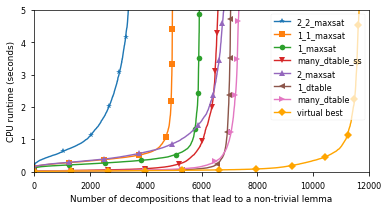

In [48]:
# Cactus plot for grammar finding methods

plt.figure(figsize=(5.5,3))

tstp_dataset = \
    (data.grammar_size>0)& \
    data.beausol& \
    data.is_tstp
for marker, method in zip("*sov^<>1", sorted(set(data[tstp_dataset].method),
                     key = lambda m: len(data[tstp_dataset&(data.method==m)&(data.time_grammar<5000)]))):
    plt.plot(
        data[(data.method==method)&tstp_dataset].
            time_grammar.sort_values().values / 1000,
        label=method,
        marker=marker, markevery=0.1)

virtual_best = data[tstp_dataset].groupby('file').time_grammar.min()
plt.plot(virtual_best.sort_values().values / 1000, label='virtual best', color='orange',
         marker='D', markevery=0.1)

plt.xlabel('Number of decompositions that lead to a non-trivial lemma')
plt.ylabel('CPU runtime (seconds)')
plt.ylim(0,5)
plt.xlim(0,12000)
plt.legend(loc='upper right', framealpha=0.7)
plt.tight_layout()
plt.savefig('grammar_finding_cactus.pdf')

In [22]:
data[(data.beausol_scomp < 100) &
     (data.beausol_lcomp > 3) &
     (data.beausol_scomp > 1) &
     (data.time_total > 30000) &
     data.is_tstp &
     ~data.file.str.contains('SY')] \
    .sort_values('beausol_scomp')[['file', 'method', 'beausol', 'time_total']]

,file,method,beausol,time_total
232580,proofs/Solutions/SEU/SEU236+2/ET---0.2.THM-CRf.s,2_2_maxsat,"[¬(subset(x_2_0, x_2_1) ∧ in(x_2_1, x_2_0))]",32637.0
658258,proofs/Solutions/LCL/LCL674+1.015/SPASS---3.7.THM-Ref.s,many_dtable,"[r1(skc1, x1) ∧ p101(x1) ⊃ p102(x1)]",38701.0
658256,proofs/Solutions/LCL/LCL674+1.015/SPASS---3.7.THM-Ref.s,1_1_maxsat,"[r1(skc1, x_2) ∧ p101(x_2) ⊃ p102(x_2)]",47479.0
658259,proofs/Solutions/LCL/LCL674+1.015/SPASS---3.7.THM-Ref.s,1_dtable,"[r1(skc1, x) ∧ p101(x) ⊃ p102(x)]",42721.0
658262,proofs/Solutions/LCL/LCL674+1.015/SPASS---3.7.THM-Ref.s,1_maxsat,"[r1(skc1, x_1) ∧ p101(x_1) ⊃ p102(x_1)]",39172.0
974212,proofs/Solutions/NUM/NUM051-1/Vampire---4.0.UNS-Ref.s,2_2_maxsat,"[¬(member(x_2_0, x_2_1) ∧ member(x_2_0, complement(#c(universal_class: i))))]",58532.0
658263,proofs/Solutions/LCL/LCL674+1.015/SPASS---3.7.THM-Ref.s,many_dtable_ss,"[r1(skc1, x1) ∧ p101(x1) ⊃ p102(x1)]",57482.0
939482,proofs/Solutions/NUM/NUM154-1/ET---0.2.UNS-CRf.s,many_dtable,"[¬(member(x1, complement(#c(universal_class: i))) ∧ member(x1, null_class))]",31899.0
891546,proofs/Solutions/SET/SET514-6/E---FNT-1.9.1.UNS-CRf.s,many_dtable,"[¬(member(x1, complement(#c(universal_class: i))) ∧ member(x1, null_class))]",60492.0
939483,proofs/Solutions/NUM/NUM154-1/ET---0.2.UNS-CRf.s,1_dtable,"[¬(member(x, complement(#c(universal_class: i))) ∧ member(x, null_class))]",33864.0


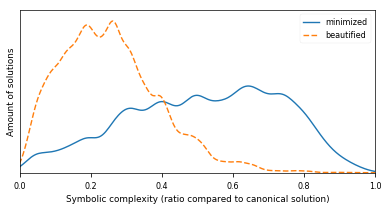

In [53]:
plt.figure(figsize=(5.5,3))
tstp_success = data[data.is_tstp&data.beausol]
(tstp_success.minsol_scomp/tstp_success.cansol_scomp).plot.kde(label='minimized')
(tstp_success.beausol_scomp/tstp_success.cansol_scomp).plot.kde(label='beautified', linestyle='--')
plt.legend()
plt.xlim(0,1)
plt.xlabel('Symbolic complexity (ratio compared to canonical solution)')
plt.ylim(0,3.2)
plt.yticks([])
plt.ylabel('Amount of solutions')
plt.tight_layout()
plt.savefig('improvement_comp_density.pdf')

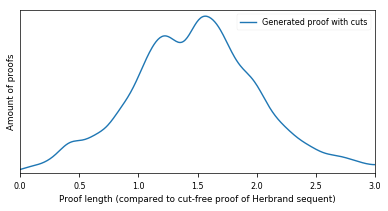

In [80]:
plt.figure(figsize=(5.5,3))
tstp_success = data[data.is_tstp&data.beausol]
#(tstp_success.hs_lkinf/tstp_success.lkinf_input).plot.kde(label='hs')
(tstp_success.lkinf_output/tstp_success.hs_lkinf).clip(0,4).plot.kde(label='Generated proof with cuts')
plt.legend()
plt.xlim(0,3)
plt.xlabel('Proof length (compared to cut-free proof of Herbrand sequent)')
plt.ylim(0,0.8)
plt.yticks([])
plt.ylabel('Amount of proofs')
plt.tight_layout()
#plt.savefig('improvement_comp_density.pdf')

(0, 1)

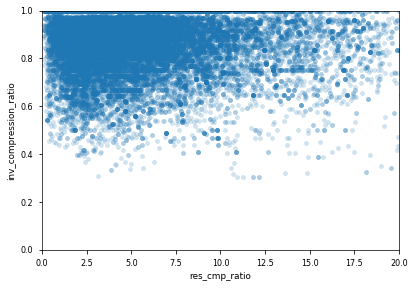

In [99]:
plt.figure(figsize=(5.5,3))
data['lk_cmp_ratio2'] = data.lkinf_output/data.hs_lkinf
data['res_cmp_ratio'] = data.lkinf_output/data.resinf_input
data[data.is_tstp].plot.scatter('res_cmp_ratio','inv_compression_ratio', alpha=0.2)
plt.xlim(0,20)
plt.ylim(0,1)

In [102]:
data[data.is_tstp & (data.res_cmp_ratio < 0.2)][ \
['beausol', 'grammar_size', 'termset', 'lkinf_output', 'hs_lkinf', 'resinf_input']]

,beausol,grammar_size,termset,lkinf_output,hs_lkinf,resinf_input
784571,"[add(\n multiply(\n multiply(\n x,\n multiply(\n add(x, inverse(x...",49.0,58.0,50.0,74.0,345.0
784570,"[add(\n multiply(\n multiply(\n x1,\n multiply(\n add(x1, inverse...",49.0,58.0,50.0,74.0,345.0
327723,"[mult(mult(#c(unit: i), a), ld(a, mult(a, mult(a, mult(x, a))))) =\n mult(mult(a, mult(a, x)), a)]",45.0,48.0,40.0,59.0,413.0
327722,"[mult(mult(#c(unit: i), x1), mult(x1, mult(x2, x1))) =\n mult(mult(x1, mult(x1, x2)), x1)]",45.0,48.0,40.0,59.0,413.0
327727,"[mult(mult(#c(unit: i), x2), mult(x2, mult(x3, x2))) =\n mult(\n mult(\n #c(unit:...",37.0,48.0,40.0,59.0,413.0
365107,"[mult(x, op_d) = mult(op_c, x)]",29.0,30.0,38.0,39.0,257.0
365110,"[op_e =\n mult(\n mult(rd(op_c, mult(x_1, #c(X_39: i))), #c(X_39: i)),\n mult(rd(mu...",28.0,30.0,24.0,39.0,257.0
365106,"[mult(x1, op_d) = mult(op_c, x1)]",29.0,30.0,38.0,39.0,257.0
1010056,"[hAPP(c_List_Oappend(#c(v1_0: i)), c_List_Olist_ONil(#c(v1_0: i))) =\n c_COMBI(x_2)]",22.0,24.0,146.0,116.0,1018.0
1010059,"[hAPP(c_List_Oappend(#c(v1_0: i)), c_List_Olist_ONil(#c(v1_0: i))) =\n c_COMBI(x)]",22.0,24.0,146.0,116.0,1018.0


In [24]:
# Added productions during beautification
tstp_success = data[data.is_tstp&data.beausol]
(tstp_success.beaugrammar_size-tstp_success.grammar_size).describe(percentiles = [.25, .5, .75, .80, .85])

count    44691.000000
mean         8.213197
std         17.898103
min          0.000000
25%          0.000000
50%          2.000000
75%          8.000000
80%         11.000000
85%         15.000000
max        426.000000
dtype: float64

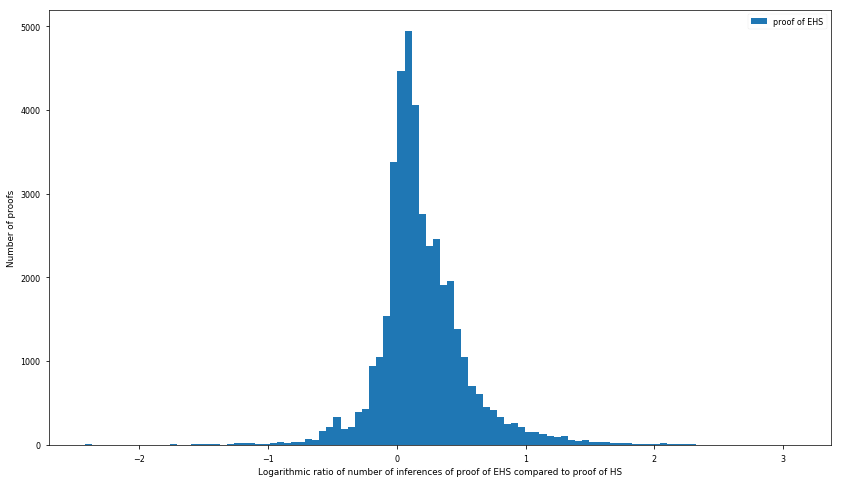

In [25]:
plt.figure(figsize=(14,8))
tstp_ok = data[data.is_tstp&(data.status=='ok')&data.ehs_lkinf]
(np.log(tstp_ok.ehs_lkinf/tstp_ok.hs_lkinf)/np.log(10)).plot.hist(label='proof of EHS', bins=100)
plt.legend()
plt.ylabel('Number of proofs')
plt.xlabel('Logarithmic ratio of number of inferences of proof of EHS compared to proof of HS')

(0, 500)

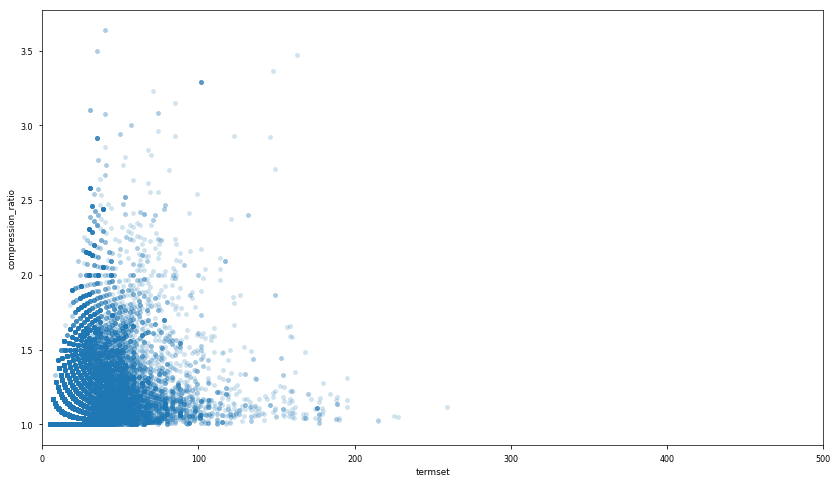

In [26]:
data[data.is_tstp&data.beausol&(data.method!='reforest')].plot.scatter('termset', 'compression_ratio',
                          alpha=0.2, figsize=(14,8))
plt.xlim(0,500)

(0, 1)

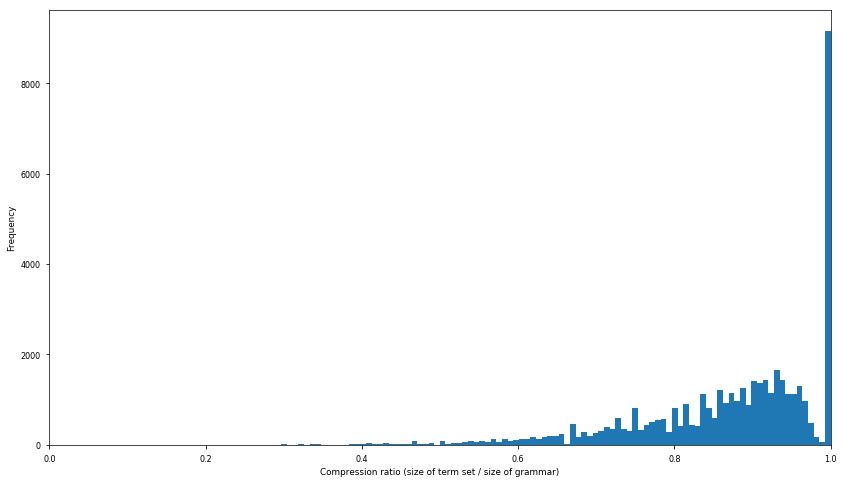

In [27]:
plt.figure(figsize=(14,8))
data[data.is_tstp&data.beausol&data.is_tstp&(data.termset_trivial==False)].inv_compression_ratio.plot.hist(bins=100)
plt.xlabel('Compression ratio (size of term set / size of grammar)')
plt.xlim(0, 1)

In [28]:
# Number of proofs in TSTP library
num_tstp = len(set(data[data.is_tstp].file)); num_tstp

138005

In [29]:
# Number of proofs we can parse
num_tstp_parsed = len(set(data[data.is_tstp&data.termset].file)); num_tstp_parsed

68198

In [30]:
# Number of trivial termsets
num_trivial = len(set(data[data.is_tstp&data.termset_trivial].file)); num_trivial

32714

In [31]:
# Number of non-trivial termsets
num_nontrivial = len(set(data[data.is_tstp&(data.termset_trivial==False)].file)); num_nontrivial

35480

In [32]:
# Number of grammars generated
num_grammar_gen = len(set(data[data.is_tstp&data.grammar_size].file)); num_grammar_gen

19122

In [33]:
# Number of lemmas generated
num_lemmas_gen = len(set(data[data.is_tstp&data.beausol].file)); num_lemmas_gen

12035

In [34]:
# Solutions for trivial termsets
data[data.is_tstp &
     data.termset_trivial &
     (data.grammar_size>0) &
     (data.beausol_scomp<10) &
     (data.beausol_scomp>1)
    ][['file', 'beausol']]

,file,beausol


In [35]:
# Number of proofs with trivial termsets where we found a grammar
len(set(data[data.is_tstp&data.termset_trivial&(data.grammar_size>0)].file))

0

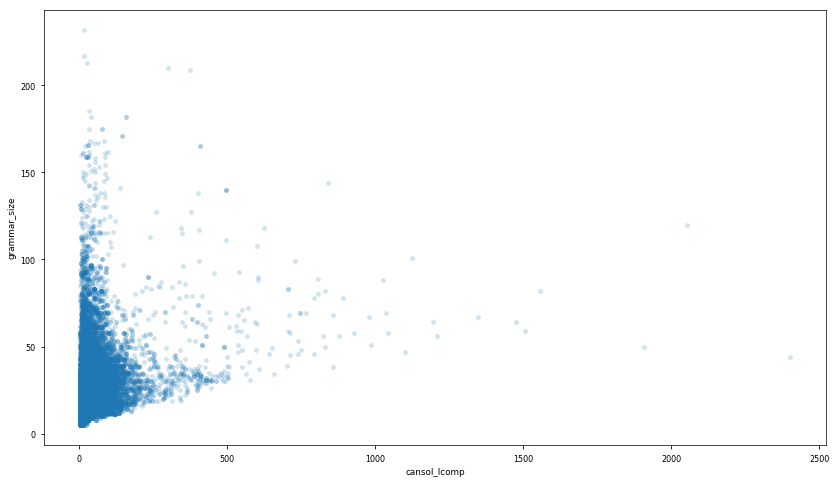

In [36]:
# Size of canonical solution vs grammar size
tstp_success = data[data.is_tstp&data.beausol]
tstp_success.plot.scatter('cansol_lcomp', 'grammar_size', figsize=(14,8), alpha=0.2)

In [37]:
data[data.status=='cutintro_noncovering_grammar'][['file','method']]

,file,method


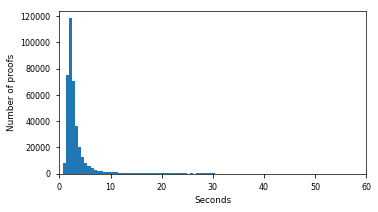

In [38]:
(data[data.time_total>0].time_total/1000).plot.hist(xlim=(0,60), bins=100, figsize=(5.5,3))
plt.xlabel('Seconds')
plt.ylabel('Number of proofs')
plt.savefig('timedist.pdf')

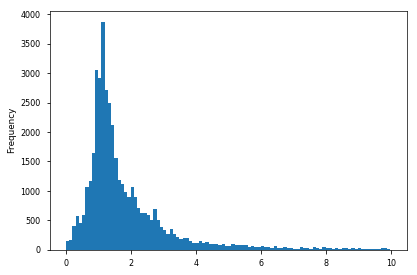

In [39]:
data[data.lk_cmp_ratio<10].lk_cmp_ratio.plot.hist(bins=100)

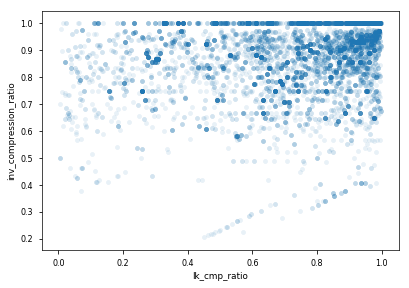

In [40]:
data[data.lk_cmp_ratio<1].plot.scatter('lk_cmp_ratio', 'inv_compression_ratio', alpha=0.1)

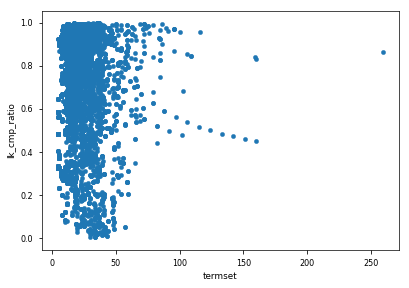

In [41]:
data[data.lk_cmp_ratio<1].plot.scatter('termset', 'lk_cmp_ratio')

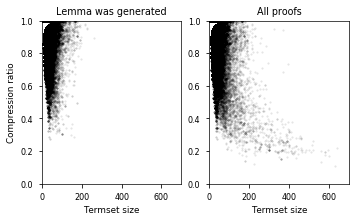

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5.5,3))
data[data.is_tstp&data.has_sol].plot.scatter('termset', 'inv_compression_ratio', ax=axes[0],
                                             c='black', alpha=0.1, ylim=(0,1), xlim=(0,700), s=3)
data[data.is_tstp].plot.scatter('termset', 'inv_compression_ratio', ax=axes[1],
                                c='black', alpha=0.1, ylim=(0,1), xlim=(0,700), s=3)
axes[0].set_ylabel('Compression ratio')
axes[1].set_ylabel('')
for i in range(2): axes[i].set_xlabel('Termset size')
axes[0].set_title('Lemma was generated')
axes[1].set_title('All proofs')
for ax in axes: ax.set_rasterized(True)
plt.savefig('ratio_scatter.pdf', rasterized=True, dpi=300)

In [43]:
data.is_tstp.sum()

966035